In [ ]:
import dask
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seawater as sw
import xarray as xr
xr.set_options(display_style="html")

# import hvplot.xarray

import dcpy
import pump

# import facetgrid

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 120

xr.set_options(keep_attrs=False)

import distributed
import dask_jobqueue

if "client" in locals():
    client.close()
    cluster.close()

cluster = dask_jobqueue.PBSCluster(
    cores=36, processes=9, memory="109GB", walltime="02:00:00", project="NCGD0011"
)

client = dask.distributed.Client(cluster)
cluster

import zarr
compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=2)

In [ ]:
cluster.adapt(minimum=2, maximum=36, wait_count=600)

In [ ]:
cluster = dask.distributed.LocalCluster(processes=True, n_workers=4)

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [ ]:
client = distributed.Client(cluster)

In [ ]:
cluster.close()

In [ ]:
%aimport l2py
import glob
import xarray as xr

In [ ]:
dirname = "../datasets/modis/"

# TODO

1. Need to make stuff robust to -ve/+ve lons
    - [x] this might involve using the region.
    - [x] make sure that lon_min & lon_max are same sign
    - [x] use that to determine which way to wrap the swath longitudes


2. Make it easy to resample and save to zarr
    - Part of the issue is the problem of passing the GridDefinition object around.
    - I'll have to be careful because the region for mapping is defined in two different places :/

In [ ]:
import glob
import dask
import tqdm
import l2py

from l2py.plot import plot_swath_simple
from l2py.resample import get_regular_grid  #, resample


def resample(ds, region, debug=False):
    print("entering resample")
    from pyresample import geometry, image
    import xarray as xr
    
    if isinstance(ds, str):
       ds = xr.open_dataset(ds)

    # this regular grid does what I want
    for var in ["lat", "lon", "quality_level"]:
        ds[var].load()
        
    lon_min, lon_max, lat_min, lat_max = region
    lo, la = np.meshgrid(np.arange(lon_min, lon_max, 0.01), np.arange(lat_min, lat_max, 0.01))
    grid = geometry.GridDefinition(lo, la)
    lon, lat = grid.get_lonlats()

    in_box = (
        (ds.lon >= (lon_min - 5))
        & (ds.lon <= (lon_max + 5))
        & (ds.lat >= (lat_min - 5))
        & (ds.lat <= (lat_max + 5))
    )

    reduced = ds.squeeze()  #ds.where(in_box).dropna("ni", how="all").dropna("nj", how="all")
    good_data = reduced.sea_surface_temperature.where(reduced.quality_level == 5)

    swath_def = geometry.SwathDefinition(good_data.lon, good_data.lat)
    swath_con = image.ImageContainerNearest(
        good_data.values, swath_def, radius_of_influence=500, nprocs=1
    )
    result = swath_con.resample(grid).image_data
    
    #qual_con = image.ImageContainerNearest(
    #    reduced.quality_level.values, swath_def, radius_of_influence=500, nprocs=1
    #)
    #quality = qual_con.resample(grid).image_data
    
    #result = np.where(quality == 5, result, np.nan)
    result = np.where(result > 0, result, np.nan) - 273

    print("leaving resample")
    if debug:
        lon, lat = grid.get_lonlats()
        da = xr.DataArray(
            result, dims=["lat", "lon"], coords={"lon": lon[0, :], "lat": lat[:, 0]}
        )
        da = da.where(da > 0)

        f, ax = plt.subplots(2, 1, constrained_layout=True, sharex=True, sharey=True)

        kwargs=dict(x="lon", y="lat", cmap=mpl.cm.Spectral_r)
        hdl = da.plot(ax=ax[1], robust=True, **kwargs)
        plot_swath_simple(ds, ax=ax[1])

        good_data.plot(ax=ax[0], vmin=hdl.norm.vmin, vmax=hdl.norm.vmax, **kwargs)
        plot_swath_simple(ds, ax=ax[0])

        ax[0].set_ylim([lat_min - 5, lat_max + 5])
        ax[0].set_xlim([lon_min - 5, lon_max + 5])

    return result


class L2:
    def __init__(self, dirname, region=None):
        self.dirname = dirname
        self.files = sorted(glob.glob(dirname + "*.nc"))
        self.dsets = None
        self.region = region
        self.grid, self.lon, self.lat = get_regular_grid(region)
        self.time = None

    def __repr__(self):
        if self.time is not None:
            time_str = f"{str(self.time[0].values)} -> {str(self.time[-1].values)}"
        else:
            time_str = "unloaded"
        return (
            f"{self.dirname}: {len(self.files)} files \n"
            f"region: {self.region} \n"
            f"time: {time_str}"
        )

    def open(self, index=None, compute=True, load=False):
        """ 
        Open files in `dirname`.
        
        """
        if index is not None:
            subset = self.files[index]
        else:
            subset = self.files

        if load:
            func = xr.load_dataset
        else:
            func = xr.open_dataset

        dsets = [
            dask.delayed(func)(file, chunks={"ni": -1, "nj": -1}) for file in subset
        ]

        self.times = xr.open_mfdataset(
            subset,
            combine="nested",
            parallel=True,
            preprocess=lambda x: x.squeeze().reset_coords()["time"],
            concat_dim="time",
        )

        if compute:
            return dask.compute(*dsets)
        else:
            return dsets

    def plot_swath_outlines(self):
        for ds in tqdm.tqdm(self.dsets):
            l2py.plot.swath_outline(ds, region=self.region)
            
            
def collate(files, region, lat, lon, times, index=None):

    # Build up delayed pipeline
    #    1. Open files
    #    2. Resample
    #    3. Collate
    

    # TODO: move file loading to resample
    # actually I'll need to load time first...
    # _ = self.open(index, load=False, compute=False)
    resampled = [dask.delayed(resample)(ds, region=region) for ds in files]
    tasks = [
        dask.array.from_delayed(rr, dtype=np.float64, shape=lon.shape)
        for rr in resampled
    ]
    final = dask.array.stack(tasks)
    
    result = xr.DataArray(
        final,
        dims=["time", "lat", "lon"],
        coords={"lat": lat[:, 0], "lon": lon[0, :], "time": times},
    )
    
    # WARNING: This mean is needed because we have pixels overlapping :(
    # Maybe I need to groupby at 12H frequency?
    # TODO: I should worry about local time
    daily = result.groupby(times.dt.floor("D"))

    merged = xr.Dataset()
    merged["sst"] = daily.mean("time").astype("float32")
    merged.sst.attrs["long_name"] = "L2P SST"
    merged.sst.attrs["units"] = "C"
    merged.sst.attrs["description"] = "Collated L2P SST images"

    merged["counts"] = (
        daily
        .count()
        .astype(np.int16)
    )
    merged["counts"].attrs[
        "description"
    ] = "Number of clean observations in each pixel. Ideally this would be 1. But we have some overlaps."


    return merged.rename({"floor": "time"})


pac = L2(dirname, region=[-170, -95, -10, 10])
pac

../datasets/modis/: 19059 files 
region: [-170, -95, -10, 10] 
time: unloaded

In [ ]:
files = pac.files[:500]

times = xr.open_mfdataset(
            files,
            combine="nested",
            parallel=True,
            preprocess=lambda x: x.squeeze().reset_coords()["time"],
            concat_dim="time",
        )
merged = collate(files, region=pac.region, lat=pac.lat, lon=pac.lon, times=times)

In [ ]:
dask.config.set(fuse_ave_width=11)

In [ ]:
dcpy.util.dask.batch_to_zarr(merged,
              file="/glade/u/home/dcherian/scratch/pump_modis_l2p_merged.zarr", 
              dim="time",
              batch_size=100,
              encoding={"sst": {"compressor": compressor}})

In [ ]:
modis = xr.open_zarr("/glade/u/home/dcherian/scratch/pump_modis_l2p_merged.zarr")

In [ ]:
def save_image(block, dim="time"):
    import matplotlib.pyplot as plt
    if sum(block.shape) > 0:
        # workaround 1:
        # xarray passes a zero shaped array to infer what this function returns. 
        # we can't run plot, so avoid doing that
        f = plt.figure()
        f.set_size_inches((10, 5))
        ax = f.subplots(1, 1, squeeze=True)

        # xarray plotting goodness is available here!
        block.plot(x="lon", ax=ax, robust=True, vmin=22.5, vmax=27.5, cmap=mpl.cm.Spectral_r, 
                   cbar_kwargs={"orientation": "horizontal", "aspect": 40, "shrink": 0.8, "extend": "both"})
   
        f.savefig(f"images/aqua/{block[dim].values[0]}.png", dpi=220)
        plt.close(f)

    # workaround 2:
    # map_blocks expects to receive an xarray thing back.
    # Just send back one value. If we send back "block" that's like computing the whole dataset!
    return block["time"]
    

# I want to animate in time, so chunk so that there is 1 block per timestep.
tasks = modis.sst.chunk({"time": 1, "lat": -1, "lon": -1}).map_blocks(save_image)
#tasks.compute()

#save_image(modis.sst.isel(time=[180])[:,::4,::4])
#modis.sst.isel(time=10).plot(x="lon", cmap=mpl.cm.Spectral_r, robust=True, 
#                              cbar_kwargs={})


In [ ]:
tasks.compute()

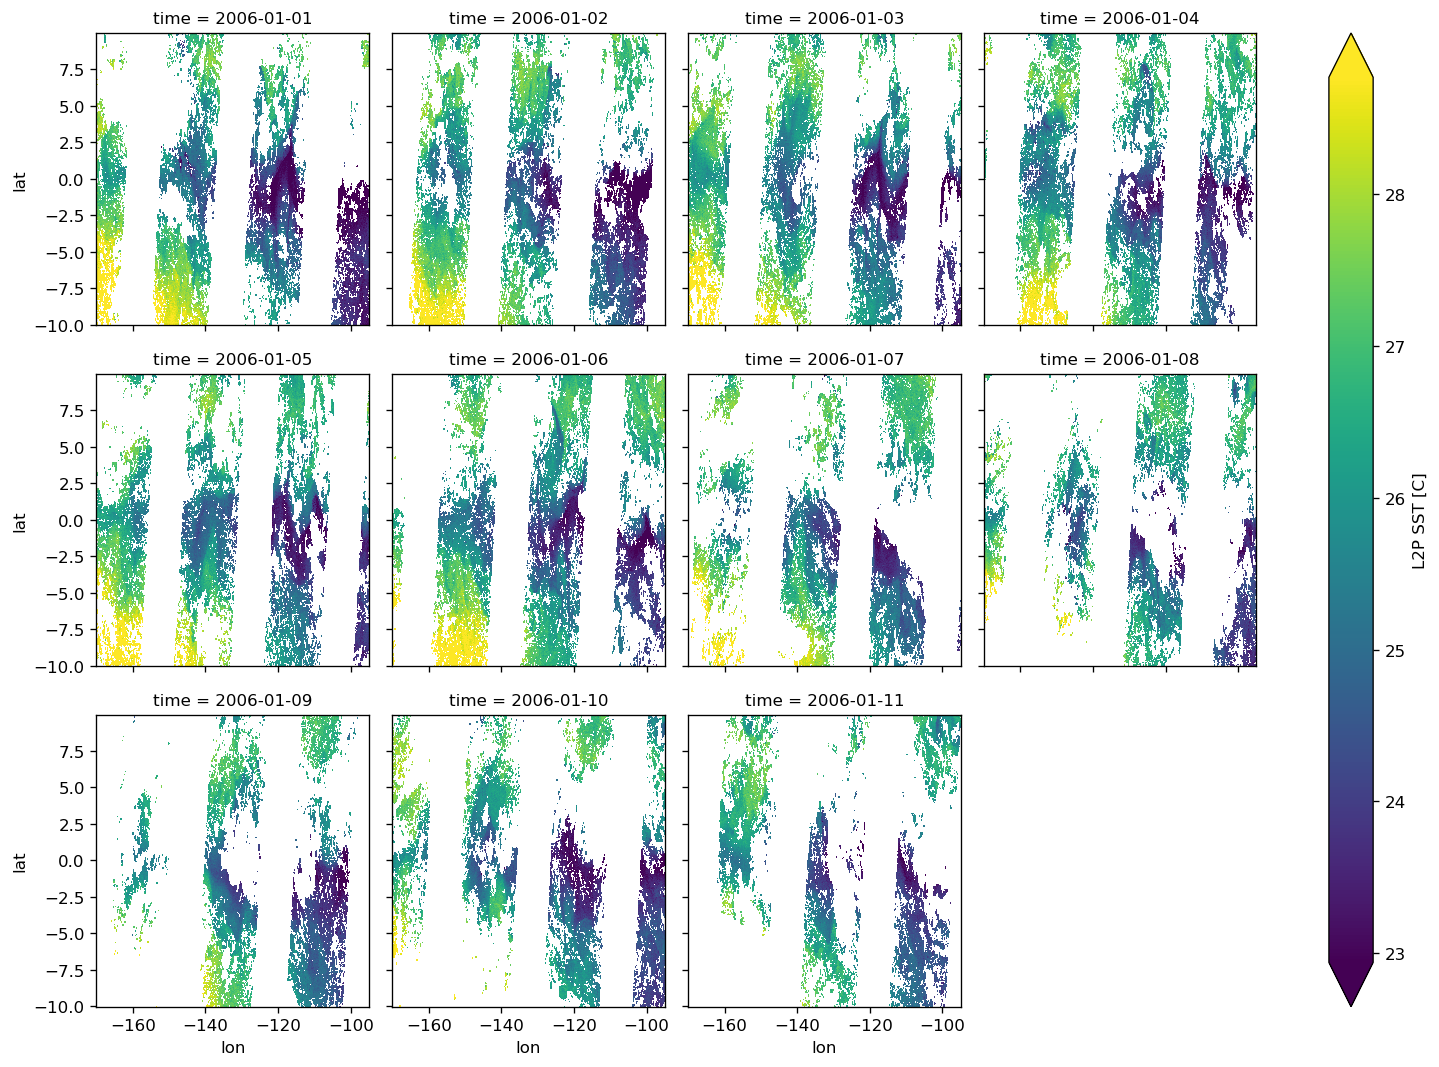

In [ ]:
arr.sst[:, ::4, ::4].plot(col="time", col_wrap=4, robust=True)

In [ ]:
ds = xr.load_dataset(pac.files[0])

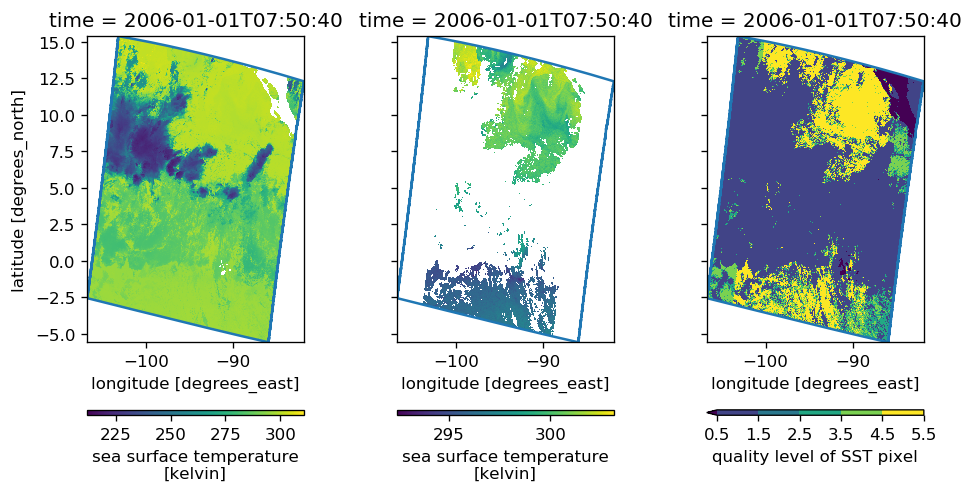

In [ ]:
l2py.plot.swath(ds)

entering resample


/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater


leaving resample


/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


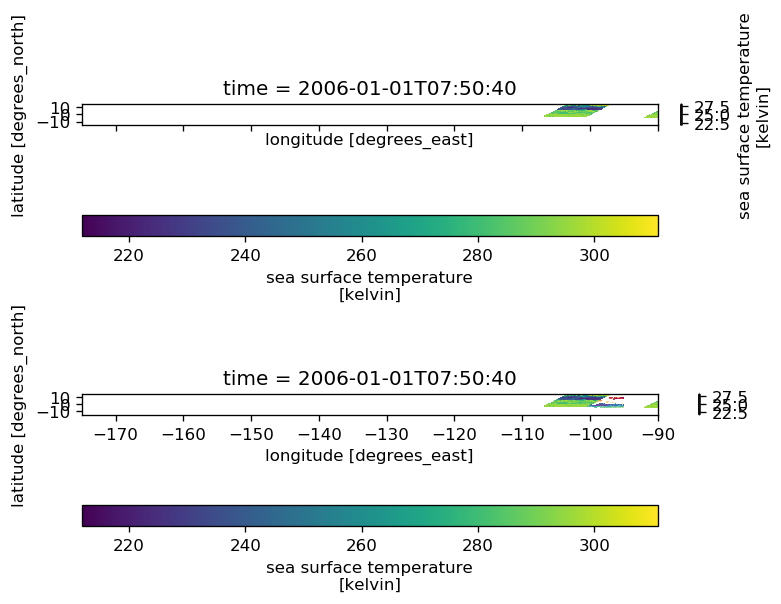

In [ ]:
a = resample(pac.files[0], region=pac.region)

In [ ]:
means = collate.groupby(collate.time.dt.day).mean()

In [ ]:
dask.config.set(fuse_ave_width=11)

In [ ]:
self = pac

resampled = [dask.delayed(resample)(ds, region=self.region) for ds in self.files[:20]]
tasks = [
    dask.array.from_delayed(rr, dtype=np.float64, shape=self.lon.shape)
    for rr in resampled
]
final = dask.array.stack(tasks, 0)
result = xr.DataArray(
            final,
            dims=["time", "lat", "lon"],
            coords={"lat": self.lat[:, 0], "lon": self.lon[0, :], "time": self.times[:20]},
        )

In [ ]:
result = xr.DataArray(
            final,
            dims=["time", "lat", "lon"],
            coords={"lat": self.lat[:, 0], "lon": self.lon[0, :], "time": self.times[:20]},
        ).compute()

In [ ]:
arr[:4,:,:].mean(axis=0).compute(scheduler="single-threaded")

entering resample


/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater


leaving resample
entering resample


/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater


leaving resample
entering resample


/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater


leaving resample
entering resample


/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater


leaving resample


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
import zarr

compressor = zarr.Blosc(cname="zstd", clevel=3, shuffle=2)

In [ ]:
dask.config.set(fuse_ave_width=5)

In [ ]:
collate.isel(time=slice(1)).to_zarr(
        "/glade/scratch/dcherian/eqpac-modis-l2p-2006.zarr",
        mode="w",
        consolidated=True,
        encoding={"sst": {"compressor": compressor}},
    )

TypeError: string indices must be integers

In [ ]:
dtime=100
for itime in tqdm.tqdm(range(1, collate.sizes["time"], dtime)):
    collate.isel(time=slice(itime, itime+dtime)).to_zarr(
        "/glade/scratch/dcherian/eqpac-modis-l2p-2006.zarr",
        mode="a",
        append_dim="time",
        consolidated=True,
    )

In [ ]:
load = collate.isel(time=24).load()

<IPython.core.display.Javascript object>


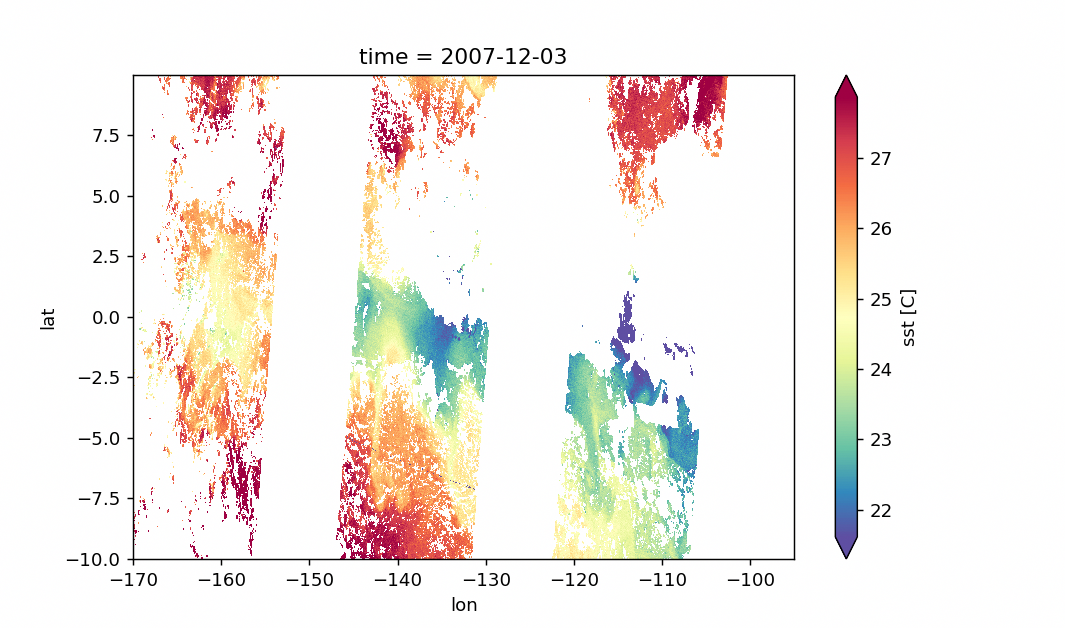

In [ ]:
%matplotlib notebook

collate.sst.isel(time=700).plot(cmap=mpl.cm.Spectral_r, robust=True)

100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


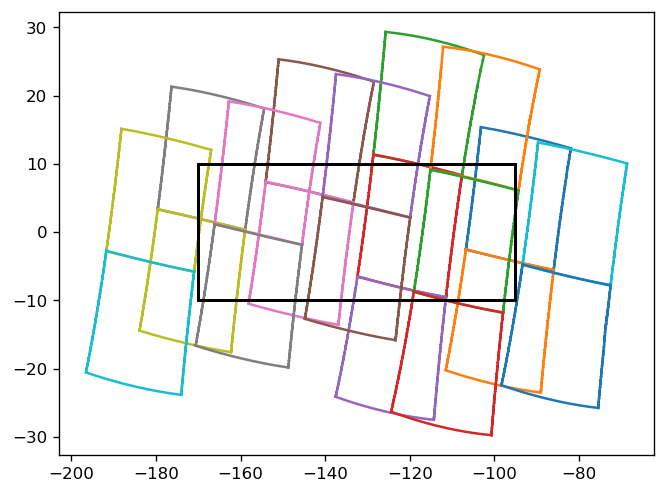

In [ ]:
pac.plot_swath_outlines()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

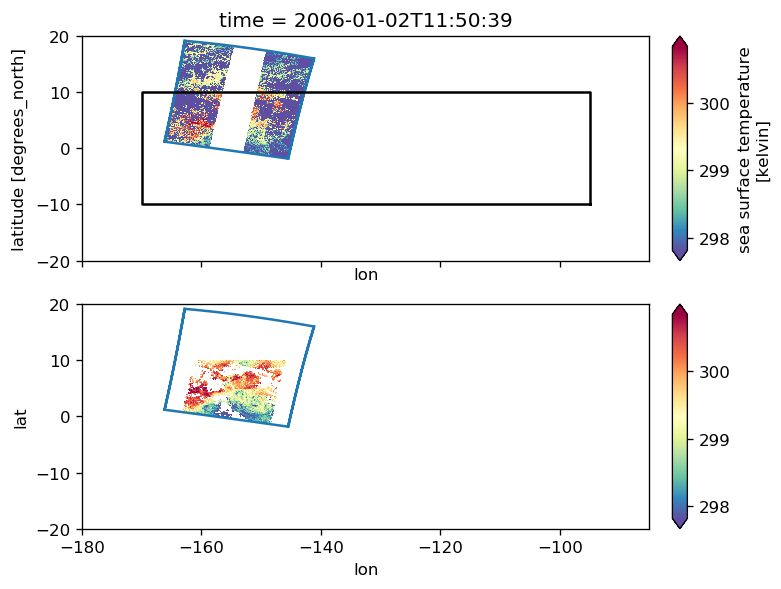

In [ ]:
l2py.resample.resample(pac.dsets, 
                       region=pac.region, 
                       debug=True)